# Titulo


### Index:
## Dataset overview
## Objectives
## Exploratory Data Analysis

- Data review and checks
- Features distributions
- Correlation analysis
- Target distribution

## Building a Random Forest Classifier model
- Creating the base model
- Cross Validation
- Hypermarater tunning
- Preparing the model for new predictions

## Conclusions

# Dataset overview

The data is related with eruption prevention system, which is capable to predict what type of eruption a volcano will have based on the vibrations detected by its sensors during the days prior to the eruption.

The metric used to evaluate the objective will be 'f1-score'.

This exercise corresponds to the challenge **Talent Digital Hackaton**, conducted online at https://nuwe.io

## Dataset explanation

The dataset has 2,100 instances, 6 features and a target.

- **Features**: It contains 6 features in 6 columns, which are the measured vibrations of the different sensors the days before the volcanic eruption
- **Target**: The target corresponds to the label that classifies the types of eruptions:

    - Target 0 corresponds to a type eruption Pliniana
    - Target 1 corresponds to a type eruption Peleana
    - Target 2 corresponds to a type eruption Vulcaniana
    - Target 3 corresponds to a type eruption Hawaiana
    - Target 4 corresponds to a type eruption Estromboliana


# Objectives

The objective of this project is to **develop a predictive model** based on Random Forests that allows knowing the type of eruption that a volcano will have based on the vibrations measured by the sensors the days before the volcanic eruption.

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [4]:
data = pd.read_csv('jm_train.csv', engine='python')

In [4]:
data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


# Exploratory data analysis

## Data review and checks

- **Size and type of data**

In [10]:
print('The dataset has', data.shape[0], 'rows and', data.shape[1], 'columns.')

The dataset has 2100 rows and 7 columns.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


We observe that all the features are float and the target is an integer

- Check null values

In [9]:
data.isnull().sum()

feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
target      0
dtype: int64

We observe we don't have any null values in the dataset

- **Handling duplicate values**

In [11]:
data.duplicated().sum()

0

There aren't duplicate values in the dataset

- **Statistical description of data**

In [18]:
data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
feature1,2100.0,-0.20,1.54,-6.68,-1.17,-0.44,0.89,4.57
feature2,2100.0,0.20,1.61,-5.38,-0.88,0.32,1.32,6.70
feature3,2100.0,-0.38,1.45,-6.15,-1.37,-0.44,0.66,4.16
feature4,2100.0,-0.21,1.44,-5.65,-1.26,-0.18,0.87,4.37
feature5,2100.0,-0.19,1.50,-5.91,-1.21,-0.20,0.85,5.07
feature6,2100.0,-0.43,1.19,-4.43,-1.13,-0.41,0.35,4.02
target,2100.0,1.98,1.41,0.00,1.00,2.00,3.00,4.00


From the numerical data summary we can observe:
- All the features have a similar range and therefore also have a similar scale
- A centered distribution with a certain symmetry is intuited

## Features distributions

We plot the distribution and the boxplot for the features

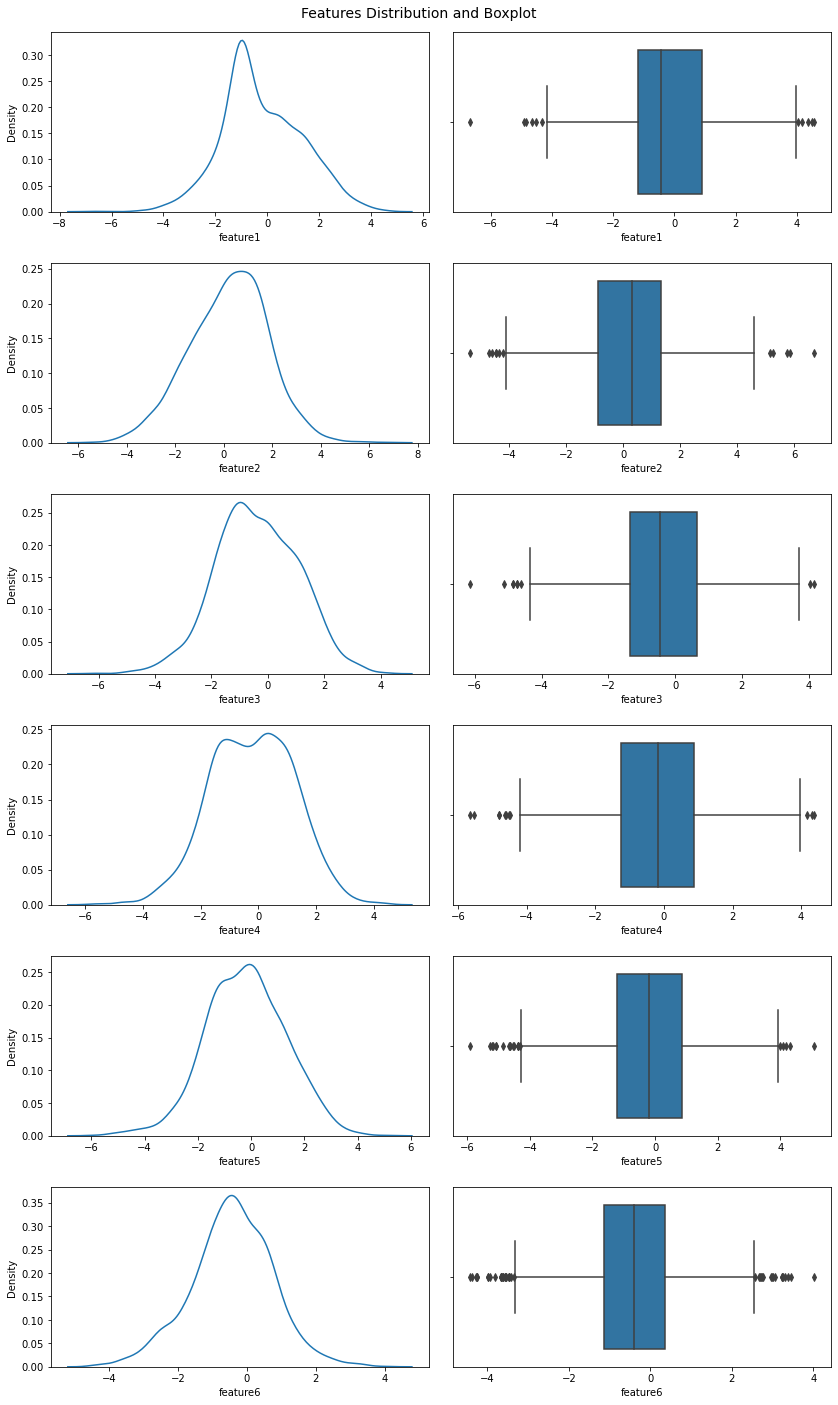

In [7]:
features=list(data.select_dtypes(float).columns)
f, axes = plt.subplots(6,2, figsize = (12, 20))
f.suptitle('Features Distribution and Boxplot', fontsize = 14 )
for i, column in enumerate(features):
    sns.kdeplot(x=data[column], data=data, ax = axes[i][0]);
    sns.boxplot(x=data[column], data=data, ax = axes[i][1]);
plt.tight_layout(pad=2);

From the feature distributions and boxplots we observe:
- The features seem close to a normal distribution
- The features have some outliers, but not far from the limits

- **Checking normal distribution**

We create an algoritm that test if features distributions follow a normal distribution. We are using **Shapiro-Wilk test**. Our hypothesis is:   
- $H_0:$ The data is normally distributed.
- $H_1:$ The data is not normally distributed.

With a significant level (**alpha**) of **0.05**

In [5]:
gaussian_df= pd.DataFrame(columns=['Feature','stat', 'p_value'])
for i in features:
    stat, p_value = shapiro(data[i])
    test={'Feature':i, 'stat':stat, 'p_value': p_value}
    gaussian_df = gaussian_df.append(test, ignore_index=True)
gaussian_df

,Feature,stat,p_value
0,feature1,0.989096,1.611365e-11
1,feature2,0.996149,3.394436e-05
2,feature3,0.997782,4.971621e-03
3,feature4,0.996859,2.655204e-04
4,feature5,0.997745,4.394508e-03
5,feature6,0.995128,2.289365e-06


As p_value is less than the significant level (alpha) for all the features, we can reject null hypothesis at 95% Significance Level and therfore we can conclude that the **features are not normally distributed**.

- **Features distribution by target**

We want to see the features distribution for each target value

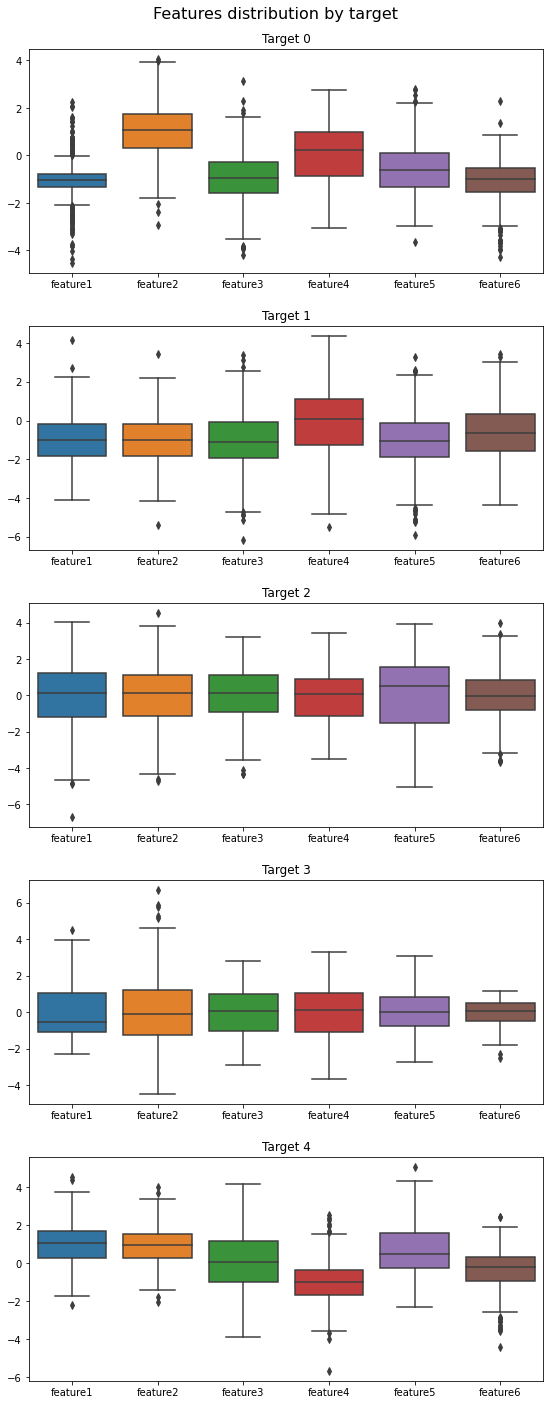

In [8]:
#Plotting boxplots for each target value
f, axes = plt.subplots(5,1, figsize = (8, 20))
f.suptitle('Features distribution by target', fontsize = 16 )
for i in range(5):
    sns.boxplot(data=data[data['target']== i][features], ax = axes[i]).set(title='Target '+ str(i));
plt.tight_layout(pad=2);

From features distribution by target we observe:
- Each of the features can have a different distribution depending on the target
- The average values of the features may be different for each target
- Each target has a different combination of mean values of the features

## Correlation analysis

We check correlation betwween the features and with our target

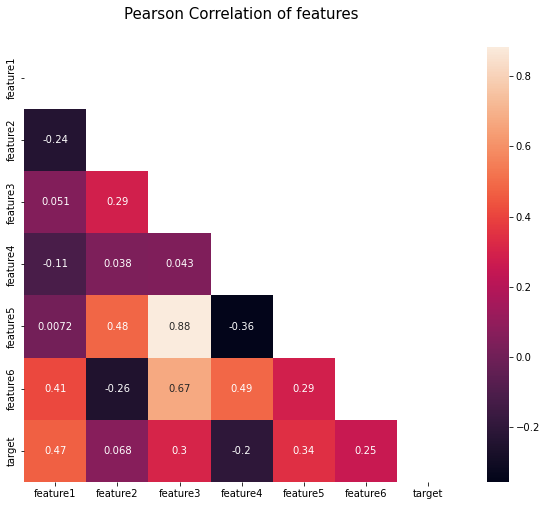

In [8]:
plt.figure(figsize=(10,8))
#colormap = plt.cm.YlGnBu

matrix = np.triu(data.corr())
plt.title('Pearson Correlation of features', y=1.05, size = 15)
sns.heatmap(data.corr(), square = True, annot = True, mask = matrix)
plt.show()

From correlation matrix we observe:
- Only feature5 is correlated with feature3 (0.88)
- There isn't significative correlation between the features and the target

Given the low level of correlation of the data, we do not propose reduction of variables for reasons of multicolinearity

## Target distribution

In [9]:
data.target.value_counts()

0    427
3    426
1    423
2    419
4    405
Name: target, dtype: int64

We observe that the target is **highly balanced**

# Building a Random Forest Classifier model

In creating the model we will consider 2 determining criteria:
- As features have a similar scale and also RandomForest does not require prior data normalization, we will **not scale the data**
- As our dataset is relatively small (2,100 registers), we will not use the split train-test technique because we would train the model with less data and therefore we would obtain a result that could be sensitive to noise and not too robust. We are using for building our model **Cross Validation with the complete dataset**, that gives better and more robusts results with small datasets 

## Creating the base model
We use **Random Forest Classifier** with the default parameters and the metric for evaluating will be **F1 macro score**

In [5]:
# We separate the variables from the target
y= data['target']
X= data.drop(['target'], axis=1)

In [4]:
# Instantiate the base model 
rf = RandomForestClassifier(random_state= 0)

## Cross Validation

Using Cross Validation to obtain F1 score for the base model

In [28]:
crossv = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
scores = cross_val_score(rf, X, y, scoring= 'f1_macro', cv = crossv)
print('Base model Cross Validation f1_score mean: {0}     std_f1: {1}'.format(np.mean(scores).round(4), np.std(scores).round(4)))

Base model Cross Validation f1_score mean: 0.7706     std_f1: 0.0275


The standard deviation of the 50 values is very low, so we can we consider the value obtained F1 as good and conclude that the model doesn't present overfitting.

## Hypermaraters tunning

In [6]:
#We get the model inicial parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [15]:
#Parameters to optimize with GridSearch
parameters ={'max_features':  [0.4, 0.5, 0.6], 
             'n_estimators': [250, 275, 300, 325, 350], 
             'max_depth': [15, 20, 25, 30], 
             'criterion': ['gini', 'entropy']}

#setting up
rf_gs = GridSearchCV(estimator = RandomForestClassifier(random_state= 0), param_grid = parameters, scoring = 'f1_macro')

#Training
rf_gs.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 20, 25, 30],
                         'max_features': [0.4, 0.5, 0.6],
                         'n_estimators': [250, 275, 300, 325, 350]},
             scoring='f1_macro')

In [16]:
print ('Best GridSearch Parameters: ', rf_gs.best_params_)
print('Best GridSearch score: ', rf_gs.best_score_)

Best GridSearch Parameters:  {'criterion': 'gini', 'max_depth': 20, 'max_features': 0.5, 'n_estimators': 325}
Best GridSearch score:  0.7758118923961627


We evaluate results of best parameters with Cross Validation:

In [29]:
rf_opt= RandomForestClassifier(n_estimators = 325, max_features= 0.5 , max_depth=20, criterion = 'gini' ,
                                 random_state=0)
crossv = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
scores = cross_val_score(rf_opt, X, y, scoring= 'f1_macro', cv = crossv)
print('f1_score mean: {0}     std_f1: {1}'.format(np.mean(scores).round(4), np.std(scores).round(4)))

f1_score mean: 0.7779     std_f1: 0.0263


- **Optimal number of trees**

Starting from the best parameters obtained by Grid Search, next we are going to look for the optimal number of estimators to see if we can improve the F1

In [31]:
for num_estimator in range (310, 330, 2):
    rf_opt1= RandomForestClassifier(n_estimators = num_estimator, max_features= 0.5 , max_depth=20, criterion = 'gini' ,
                                 random_state=0)
    crossv = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 0)   
    scores = cross_val_score(rf_opt1, X, y, scoring= 'f1_macro', cv= crossv)
    print('n_estimator= {0}   f1_score mean: {1}     std_f1: {2}'.format(num_estimator, np.mean(scores).round(4), np.std(scores).round(4)))

n_estimator= 310   f1_score mean: 0.7788     std_f1: 0.026
n_estimator= 312   f1_score mean: 0.7787     std_f1: 0.0262
n_estimator= 314   f1_score mean: 0.7785     std_f1: 0.0257
n_estimator= 316   f1_score mean: 0.7785     std_f1: 0.0263
n_estimator= 318   f1_score mean: 0.7784     std_f1: 0.0257
n_estimator= 320   f1_score mean: 0.7789     std_f1: 0.0259
n_estimator= 322   f1_score mean: 0.7786     std_f1: 0.0266
n_estimator= 324   f1_score mean: 0.7781     std_f1: 0.0261
n_estimator= 326   f1_score mean: 0.7783     std_f1: 0.0259
n_estimator= 328   f1_score mean: 0.7783     std_f1: 0.0262


We obtained a very light F1 improvement using n_estimator=320, from 0.7779 to 0.7789

**Final_model:**
- RandomForestClassifier(n_estimators = 320, max_features= 0.5 , max_depth=20, criterion = 'gini', random_state=0)
- F1 score mean: **0.7789**

## Preparing the model for new predictions

- **Create a Pipeline**

In [6]:
# Prepare the model 
final_model = RandomForestClassifier(n_estimators= 320, max_depth=20, max_features= 0.5, criterion = 'gini' 
                                     ,random_state=0)

# Prepare Pipeline 
pipeline = Pipeline( steps= [('model', final_model)])

# fit on all data 
pipeline.fit(X, y)

Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=20, max_features=0.5,
                                        n_estimators=320, random_state=0))])

- **Make predictions on test data**

In [8]:
# Open test data 
test_data = pd.read_csv('jm_X_test.csv', engine='python')
test_data.head()

,feature1,feature2,feature3,feature4,feature5,feature6
0,0.943723,-2.985473,-0.938218,3.580261,-3.038106,2.080338
1,-0.899819,1.295568,1.274513,0.718186,1.117035,0.463068
2,0.293281,-0.099317,1.874902,-0.589582,1.828441,1.011596
3,-1.134804,0.888585,-1.464499,-1.183056,-0.525729,-1.963822
4,-0.909240,1.575797,0.697212,1.197092,0.486185,0.222644


In [9]:
prediction = pipeline.predict(test_data)

In [10]:
#Create a DataFrame
outcome= pd.DataFrame({'final_status': prediction})

In [12]:
# save to csv file 
outcome.to_csv('predictions.csv', index = False )

## Conclusions
- We have use a RandomForest model for our prediction
- As the dataset is small, we have used all the registers to train the model
- Applying cross validation we have verified that the model remains stable and that there was no overfitting. We obtained a **f1 score of 0.7706**
- Through GridSearch we have adjusted the hyperparameters improving the initial model until we obtained a **F1_Score of 0.7779**
- Finally, we have optimized the number of estimators and obtained a **F1_Score of 0.7789**